<a href="https://colab.research.google.com/github/FilipNim/MKA-MLF/blob/main/MKA_MLF_Miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MKA-MLF Miniproject

In [518]:
# Import libraries
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [519]:
# Load the data from the CSV file "Data_prepared_final.csv"
data = pd.read_csv("Data_prepared_final.csv")

In [520]:
# Print data
data

,Unnamed: 0,time [s],cfo_meas,cfo_demod,gain_imb,iq_imb,or_off,quadr_err,ph_err,mag_err,evm
0,0,45181.524,-414,-421.076324,0.076097,-46.987598,-27.219631,0.104362,1.129778,0.440299,2.059935
1,1,45182.129,-414,-423.571686,0.069879,-47.852627,-26.934967,0.053158,1.050010,0.431240,1.815053
2,2,45182.550,-414,-421.033936,0.061466,-48.968697,-27.130722,-0.045913,0.989473,0.447790,1.762053
3,3,45182.971,-414,-420.103546,0.078836,-46.756973,-27.005318,0.081583,1.085091,0.443476,1.894204
4,4,45183.551,-432,-420.781097,0.066053,-47.048218,-27.358521,0.081920,1.023701,0.465225,1.805841
...,...,...,...,...,...,...,...,...,...,...,...
19195,19195,54245.724,216,215.584991,0.077551,-35.409054,-28.611925,1.875334,0.999375,1.427339,2.248822
19196,19196,54246.340,216,215.247406,0.044961,-35.508205,-27.954048,1.898758,1.031501,1.478366,2.320668
19197,19197,54246.770,216,216.761307,0.070066,-35.038486,-28.467575,2.015116,1.090227,1.468599,2.382019
19198,19198,54247.379,216,215.353516,0.048611,-35.413639,-28.528139,1.916172,0.999381,1.497681,2.283976


## Data Preprocessing

In [521]:
# Drop the first and second columns from the DataFrame
data = data.drop(data.columns[[0, 1]], axis=1)

# Initialize the StandardScaler for data normalization
scaler = StandardScaler()

# Normalize the data using the StandardScaler
normalized_data = scaler.fit_transform(data)

In [522]:
# Print normalized_data
print(normalized_data)

[[-0.10218242 -0.11905909  0.68430902 ... -0.42776025 -1.48754722
  -0.97623555]
 [-0.10218242 -0.12510636  0.55147287 ... -0.75935883 -1.49722643
  -1.28171204]
 [-0.10218242 -0.11895637  0.3717129  ... -1.01101267 -1.47954415
  -1.34782615]
 ...
 [ 1.42819676  1.42668032  0.55546696 ... -0.59217272 -0.38884086
  -0.57445562]
 [ 1.42819676  1.42326867  0.09704912 ... -0.96982704 -0.35776759
  -0.69675858]
 [ 1.42819676  1.4243443   0.40553964 ... -0.98722263 -0.45774141
  -0.75513862]]


## Optimization of constants min_samples and epsilon


In [523]:
# Range of min_samples values to consider
min_samples_values = range(1, 30)

# List to store silhouette scores for each min_samples value
silhouette_scores = []

# Compute silhouette score for each min_samples value
for min_samples in min_samples_values:
    # Fit DBSCAN clustering with current min_samples value
    dbscan = DBSCAN(min_samples)
    clusters = dbscan.fit_predict(normalized_data)

    # Check if there is at least one cluster other than noise
    unique_clusters = np.unique(clusters)
    if len(unique_clusters) > 1:
        # Compute silhouette score if there are multiple clusters
        silhouette = silhouette_score(normalized_data, clusters)
        silhouette_scores.append(silhouette)
    else:
        # Add a zero score if only one cluster is present (unable to compute silhouette)
        silhouette_scores.append(0)

# Find the index of the maximum silhouette score
optimal_min_samples_index = np.argmax(silhouette_scores)

# Optimal min_samples value
optimal_min_samples = min_samples_values[optimal_min_samples_index]

print("Optimal min_samples:", optimal_min_samples)

Optimal min_samples: 10


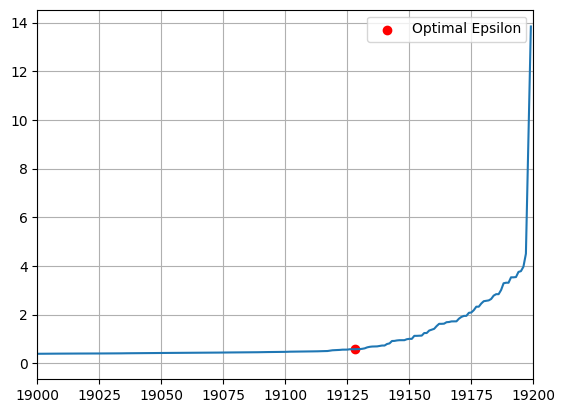

Optimal epsilon: 0.5777840896008049


In [524]:
# Fit Nearest Neighbors to find distances to nearest neighbors
neighbors = NearestNeighbors(n_neighbors=optimal_min_samples)
neighbors_fit = neighbors.fit(normalized_data)
distances, indices = neighbors_fit.kneighbors(normalized_data)

# Sort distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Find optimal epsilon using KneeLocator
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_epsilon_index = kneedle.elbow
optimal_epsilon = distances[optimal_epsilon_index]

# Plot distances with optimal epsilon marked
plt.plot(distances)
plt.grid()
plt.xlim([19000, 19200])
plt.scatter(optimal_epsilon_index, optimal_epsilon, color='red', marker='o', label='Optimal Epsilon')
plt.legend()
plt.show()

print("Optimal epsilon:", optimal_epsilon)

## Model building and results

In [525]:
# Use DBSCAN with optimal epsilon and min_samples
dbscan = DBSCAN(eps=optimal_epsilon, min_samples=optimal_min_samples)
dbscan.fit(normalized_data)

# Get cluster labels
clusters = dbscan.labels_

# Calculate number of transmitters
num_transmitters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Number of transmitters:", num_transmitters)

Number of transmitters: 4
